In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [2]:
%matplotlib inline
import utils
from utils import *
from __future__ import division, print_function

Using TensorFlow backend.


In [4]:
path = "data/weather/"
model_path = path + 'models/'
batch_size=1024

In [5]:
data = pd.read_csv(path + 'all_data.csv', index_col='DateUTC', parse_dates=True, usecols=['DateUTC','TemperatureF','DewpointF','PressureIn','WindSpeedMPH','WindSpeedGustMPH','Humidity','HourlyPrecipIn','dailyrainin','SolarRadiationWatts/m^2'])
data.index = data.index.tz_localize('UTC').tz_convert('US/Pacific')

data = data[data.TemperatureF > 0] # Remove bad temp
data = data[data.PressureIn   > 0] # Remove bad pressure
data = data[data.HourlyPrecipIn >= 0] # Remove bad rainfall

data = data.assign(forward_min = data.rolling('18h', closed='both').TemperatureF.min().shift(-18,'1h').asof(data.index))

data.head()

,TemperatureF,DewpointF,PressureIn,WindSpeedMPH,WindSpeedGustMPH,Humidity,HourlyPrecipIn,dailyrainin,SolarRadiationWatts/m^2,forward_min
DateUTC,,,,,,,,,,
2016-02-16 11:12:00-08:00,73.8,50.5,29.29,0.0,0.0,44,0.0,0.0,17.48,73.8
2016-02-16 11:14:00-08:00,74.5,50.5,29.29,0.0,0.0,43,0.0,0.0,17.48,73.8
2016-02-16 11:15:00-08:00,74.5,50.5,29.28,0.0,0.0,43,0.0,0.0,17.48,73.8
2016-02-16 11:16:00-08:00,74.5,50.5,29.27,0.0,0.0,43,0.0,0.0,17.53,73.8
2016-02-16 11:18:00-08:00,74.5,50.5,29.28,0.0,0.0,43,0.0,0.0,17.48,73.8


In [6]:
resample_time = '5T'
hour_summary = pd.DataFrame()
hour_summary['TemperatureF'] = data.TemperatureF.resample(resample_time).mean()
hour_summary['DewpointF'] = data.DewpointF.resample(resample_time).mean()
hour_summary['PressureIn'] = data.PressureIn.resample(resample_time).mean()
hour_summary['WindSpeedMPH'] = data.WindSpeedMPH.resample(resample_time).mean()
hour_summary['WindSpeedGustMPH'] = data.WindSpeedGustMPH.resample(resample_time).mean()
hour_summary['Humidity'] = data.Humidity.resample(resample_time).mean()
hour_summary['HourlyPrecipIn'] = data.HourlyPrecipIn.resample(resample_time).mean()
hour_summary['dailyrainin'] = data.dailyrainin.resample(resample_time).mean()
hour_summary['SolarRadiationWatts/m^2'] = data[['SolarRadiationWatts/m^2']].resample(resample_time).mean()
hour_summary['forward_min'] = data.forward_min.resample(resample_time).min()

hour_summary = hour_summary[hour_summary.TemperatureF.notnull()]

hour_summary = hour_summary.assign(day_of_year = hour_summary.index.dayofyear, hour = hour_summary.index.hour)



hour_summary = hour_summary.assign(threshold = 'no')
hour_summary.loc[hour_summary.forward_min < 32,'threshold'] = '32'

hour_summary = hour_summary.merge(pd.get_dummies(hour_summary.threshold, prefix='threshold'), left_index=True, right_index=True)


#data = data[:10000]

hour_summary.head()

,TemperatureF,DewpointF,PressureIn,WindSpeedMPH,WindSpeedGustMPH,Humidity,HourlyPrecipIn,dailyrainin,SolarRadiationWatts/m^2,forward_min,day_of_year,hour,threshold,threshold_32,threshold_no
DateUTC,,,,,,,,,,,,,,,
2016-02-16 11:10:00-08:00,74.15,50.5,29.290000,0.0,0.0,43.5,0.0,0.0,17.480000,73.8,47,11,no,0,1
2016-02-16 11:15:00-08:00,74.50,50.5,29.276667,0.0,0.0,43.0,0.0,0.0,17.496667,73.8,47,11,no,0,1
2016-02-16 11:20:00-08:00,74.50,50.0,29.960000,0.0,0.0,42.0,0.0,0.0,17.430000,73.8,47,11,no,0,1
2016-02-16 11:25:00-08:00,74.70,50.2,29.950000,0.0,0.0,42.0,0.0,0.0,21.900000,73.8,47,11,no,0,1
2016-02-26 13:40:00-08:00,70.30,45.0,30.070000,2.0,2.5,40.0,0.0,0.0,292.400000,44.4,57,13,no,0,1


In [24]:
training_data = hour_summary[hour_summary.index.dayofyear%10 != 0]
validation_data = hour_summary[hour_summary.index.dayofyear%10 == 0]

training_data.threshold_32.sum(), validation_data.threshold_32.sum()

(8396, 646)

In [14]:
seq_length=64
fp_fn_ratio=5

In [26]:
from pandas.tseries.offsets import *

def create_dataset(dataset, num_outputs=1, look_back=1):
    offset = DateOffset(minutes = (look_back-1) * 5)
    dataX, dataY = [], []
    for idx, row in dataset.iterrows():
        index_end = idx
        index_start = index_end - offset
        new_index = pd.date_range(start=index_start, periods=look_back, freq='5T')
        a = dataset[index_start:index_end].reindex(new_index, fill_value=0).values[:,:-num_outputs]
        dataX.append(a)
        dataY.append(row.values[-num_outputs:])
    return np.array(dataX), np.array(dataY)

In [27]:
train_x, train_y = create_dataset(training_data[['TemperatureF','DewpointF','PressureIn','WindSpeedMPH','WindSpeedGustMPH','Humidity','HourlyPrecipIn','dailyrainin','SolarRadiationWatts/m^2',
                                                 'day_of_year', 'hour',
                                                 'threshold_32']], 1, seq_length)
val_x, val_y = create_dataset(validation_data[['TemperatureF','DewpointF','PressureIn','WindSpeedMPH','WindSpeedGustMPH','Humidity','HourlyPrecipIn','dailyrainin','SolarRadiationWatts/m^2',
                                                 'day_of_year', 'hour',
                                                 'threshold_32']], 1, seq_length)

In [28]:
train_x.shape, val_x.shape, train_y.shape, val_y.shape

((110073, 64, 11), (11856, 64, 11), (110073, 1), (11856, 1))

In [29]:
model = Sequential([
    BatchNormalization(input_shape=(seq_length, train_x.shape[2])),
    
    Conv1D(64, 5, padding='causal', activation='relu'),
    BatchNormalization(),
    Conv1D(64, 5, padding='causal', activation='relu'),
    MaxPooling1D(4),
    BatchNormalization(),

    Conv1D(128, 5, padding='causal', activation='relu'),
    BatchNormalization(),
    Conv1D(128, 5, padding='causal', activation='relu'),
    MaxPooling1D(4),
    BatchNormalization(),


    Conv1D(256, 5, padding='causal', activation='relu'),
    BatchNormalization(),
    Conv1D(256, 5, padding='causal', activation='relu'),
    MaxPooling1D(4),
    BatchNormalization(),


#     Conv1D(256, 3, padding='same', activation='relu'),
#     BatchNormalization(),
#     Conv1D(256, 3, padding='same', activation='relu'),
#     BatchNormalization(),
#     MaxPooling1D(),

#     Conv1D(512, 3, padding='same', activation='relu'),
#     BatchNormalization(),
#     Conv1D(512, 3, padding='same', activation='relu'),
#     BatchNormalization(),
#     MaxPooling1D(4),
    
    Flatten(),

    Dense(512, activation='relu'),
    BatchNormalization(),
    
    Dropout(0.75),
    Dense(train_y.shape[1], activation='sigmoid'),
])
model.compile(Nadam(), 'binary_crossentropy', ['binary_accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_49 (Batc (None, 64, 11)            44        
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 64, 64)            3584      
_________________________________________________________________
batch_normalization_50 (Batc (None, 64, 64)            256       
_________________________________________________________________
conv1d_38 (Conv1D)           (None, 64, 64)            20544     
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, 16, 64)            0         
_________________________________________________________________
batch_normalization_51 (Batc (None, 16, 64)            256       
_________________________________________________________________
conv1d_39 (Conv1D)           (None, 16, 128)           41088     
__________

In [30]:
model.fit(train_x, train_y,
          epochs=20,
          batch_size=batch_size,
          validation_data=(val_x, val_y),
          class_weight={0:1, 1:fp_fn_ratio},
          callbacks=[ReduceLROnPlateau(patience=5, verbose=1)])

Train on 110073 samples, validate on 11856 samples
Epoch 1/40
110073/110073 [==============================] - 11s - loss: 0.4724 - binary_accuracy: 0.8880 - val_loss: 0.2017 - val_binary_accuracy: 0.9464
Epoch 2/40
110073/110073 [==============================] - 9s - loss: 0.1555 - binary_accuracy: 0.9673 - val_loss: 0.3726 - val_binary_accuracy: 0.9103
Epoch 3/40
110073/110073 [==============================] - 8s - loss: 0.1039 - binary_accuracy: 0.9765 - val_loss: 0.3480 - val_binary_accuracy: 0.9324
Epoch 4/40
110073/110073 [==============================] - 9s - loss: 0.0796 - binary_accuracy: 0.9822 - val_loss: 0.2704 - val_binary_accuracy: 0.9475
Epoch 5/40
110073/110073 [==============================] - 8s - loss: 0.0541 - binary_accuracy: 0.9885 - val_loss: 0.4905 - val_binary_accuracy: 0.9367
Epoch 6/40
110073/110073 [==============================] - 8s - loss: 0.0441 - binary_accuracy: 0.9905 - val_loss: 0.3637 - val_binary_accuracy: 0.9351
Epoch 7/40
109568/110073 [====

KeyboardInterrupt: 

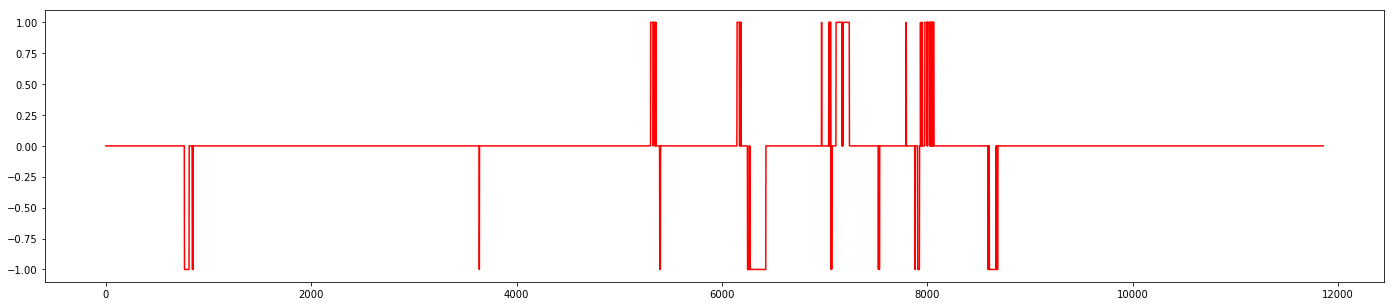

In [31]:
plt.figure(figsize=(24,5))
plt.plot(val_y-np.round(model.predict(val_x, batch_size=batch_size)), 'r')

In [ ]:
val_pseudo = np.round(model.predict(val_x, batch_size=batch_size))
combo_x = np.concatenate((train_x, val_x))
combo_y = np.concatenate((train_y, val_pseudo))
train_x.shape, val_x.shape, combo_x.shape, train_y.shape, val_y.shape, combo_y.shape

In [ ]:
model.fit(train_x, train_y,
          epochs=40,
          batch_size=batch_size,
          validation_data=(val_x, val_y),
          class_weight={0:1, 1:fp_fn_ratio},
          callbacks=[ReduceLROnPlateau(patience=5, verbose=1)])

In [ ]:
plt.figure(figsize=(24,5))
plt.plot(val_y-np.round(model.predict(val_x, batch_size=batch_size)), 'r')

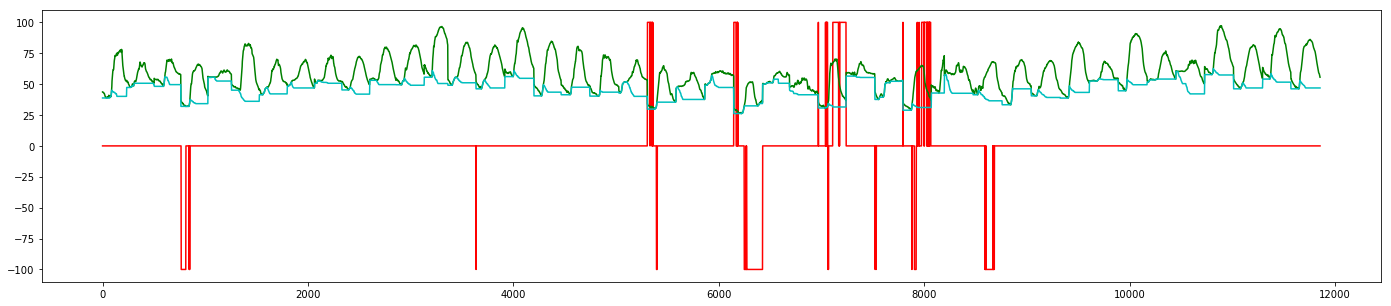

In [32]:
plt.figure(figsize=(24,5))
plt.plot((val_y-np.round(model.predict(val_x, batch_size=batch_size)))*100, 'r')
plt.plot(validation_data.TemperatureF.as_matrix(), 'g')
plt.plot(validation_data.forward_min.as_matrix(), 'c')